*<center><h1><b>Computer Assignment 5</b></h1></center>*
*<center><h3>Narges Sadat Seyed Haeri</h3></center>*


### *Problem Description*
*In this exercise, we worked with a text dataset from Twitter to detect suicidal thoughts. The aim was to learn NLP techniques using this dataset and perform sentence classification using a convolutional neural network (CNN) implemented with PyTorch.*

### *Goal*
*The goal of this exercise was to preprocess text data, use the vec2word model, implement a convolutional neural network for sentence classification with PyTorch, observe the effect of text window size on network learning, and examine the impact of regularization methods on the training process.*

---
## *Setup environment*

In [7]:
import pandas as pd
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
import gensim
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm
import gc
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
pd.options.mode.chained_assignment = None

---
## *Config*

### *Model training config*

In [8]:
LEARNING_RATE = 4e-4
WEIGHT_DECAY = 1e-2
BATCH_SIZE = 64
EPOCHS = 15
SEQUENCE_LEN = 64
CNN_FILTERS = 64
SEQUENCE_LEN_WINDOW_CONTEXT = 196

In [9]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## *Data Preparation*

### *Load Data*

In [13]:
df = pd.read_csv('twitter-suicidal-data.csv')

In [14]:
df.head(10)

,tweet,intention
0,my life is meaningless i just want to end my l...,1
1,muttering i wanna die to myself daily for a fe...,1
2,work slave i really feel like my only purpose ...,1
3,i did something on the 2 of october i overdose...,1
4,i feel like no one cares i just want to die ma...,1
5,i am great and wonderful i am worth it except ...,1
6,i ll be dead just you wait and see my last wor...,1
7,health anxiety prompting some bad thoughts in ...,1
8,everything is okay but nothing feels okay i ve...,1
9,ptsd and alcohol i had some extremely horrible...,1


### *Data Preprocessing*

In [15]:
import nltk
import emoji
import re

nltk.download(["stopwords", "punkt", "wordnet", "averaged_perceptron_tagger"])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [16]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

def convert_emoji_to_text(text):
    return emoji.replace_emoji(text, replace='')

stopwords = nltk.corpus.stopwords.words("english")
lemmatizer = WordNetLemmatizer()

def nltk_pos_tagger(nltk_tag):
    if nltk_tag.startswith('J'):
        return 'a'
    elif nltk_tag.startswith('V'):
        return 'v'
    elif nltk_tag.startswith('N'):
        return 'n'
    elif nltk_tag.startswith('R'):
        return 'r'
    else:
        return 'n'

def preprocess_data(text: str):

    # Lowercase the text
    text = text.lower()

    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)

    # Remove numbers
    text = re.sub(r'\d+', '', text)

    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+','', text, flags=re.MULTILINE)

    # Remove usernames
    text = re.sub(r'@\S+', '', text)

    # Convert emojis to text
    text = convert_emoji_to_text(text)

    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()

    # Remove non-word characters
    text = re.sub(r'\W+', ' ', text)

    # Lemmatization and tokenization of the text
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word, pos=nltk_pos_tagger(tag)) for word, tag in nltk.pos_tag(tokens)]

    # Remove stopwords
    tokens = [word for word in tokens if word not in stopwords]

    return tokens



### *Question 1: Advantages and Disadvantages of Converting Text to Lowercase*

***Advantages:***

- ``Consistency``:*Converting text to lowercase ensures that words are treated uniformly, regardless of their original case. This reduces the dimensionality of the text data, which can simplify the model and improve its performance.*
- ``Simplicity in Processing``: *It simplifies the text processing pipeline since you don’t have to handle different cases separately.*

- ``Improved Model Performance``: *By reducing the dimensionality of the text data, it can lead to more efficient and often more accurate model training, as the model does not have to learn separate representations for words that differ only in case*

***Disadvantages:***

- ``Loss of Information``: *Sometimes, the case of a word can carry important information (e.g., proper nouns or acronyms). Converting everything to lowercase might lose this nuance.*
- ``Context Understanding``: *Certain contexts or emphasis conveyed through capitalization (e.g., shouting in all caps) might be lost, which could affect sentiment analysis and other tasks where context is critical*


***Why We Perform This Preprocessing Step:***

- ``Uniformity``: *The primary reason for converting text to lowercase is to ensure uniformity in the data. It helps in treating similar words as the same entity, thereby reducing complexity.*

- ``Dimensionality Reduction``: *It reduces the number of unique tokens, which can simplify the model and improve its performance.*

- ``Standard Practice in NLP``: *It is a standard practice in Natural Language Processing (NLP) to preprocess text data in this way to achieve better and more consistent results from the models.*

### *Question 2: Pros and Cons of Removing Numbers in Text Preprocessing*

***Pros:***

- ``Noise Reduction``: *Numbers might introduce noise if they are not relevant to the task. Removing them can make the text cleaner and more focused on meaningful words.*

- ``Dimensionality Reduction``: *It reduces the number of unique tokens, which can help in managing the vocabulary size.*

***Cons:***

- ``Loss of Information``: *Numbers can sometimes carry significant information (e.g., dates, quantities, specific references). Removing them might lose valuable context.*

- ``Context Dependency``: *Whether numbers are useful or not can be highly dependent on the context and specific application.*

### *Question 3: Impact of Keeping Hashtags in Twitter Data*

*Hashtags are not removed because they can carry significant contextual and categorical information. They often encapsulate the main topic or sentiment of a tweet in a concise manner. Keeping hashtags can:*

1. *``Improve Model Performance:`` By providing additional context and keywords that are relevant to the tweet's content.*
2. *``Enhance Context Understanding:`` Hashtags can act as markers for the topics or themes being discussed, which can be useful for classification tasks.*

In [17]:
print("Samples Before Preprocessing:")
print(df['tweet'].head())
df_copy = df.copy()
df_copy['preprocessed_tweet'] = df_copy['tweet'].apply(preprocess_data)
print("\nSamples After Preprocessing:")
print(df_copy['preprocessed_tweet'].head())

Samples Before Preprocessing:
0    my life is meaningless i just want to end my l...
1    muttering i wanna die to myself daily for a fe...
2    work slave i really feel like my only purpose ...
3    i did something on the 2 of october i overdose...
4    i feel like no one cares i just want to die ma...
Name: tweet, dtype: object

Samples After Preprocessing:
0    [life, meaningless, want, end, life, badly, li...
1    [mutter, wan, na, die, daily, month, feel, wor...
2    [work, slave, really, feel, like, purpose, lif...
3    [something, october, overdose, felt, alone, ho...
4    [feel, like, one, care, want, die, maybe, feel...
Name: preprocessed_tweet, dtype: object


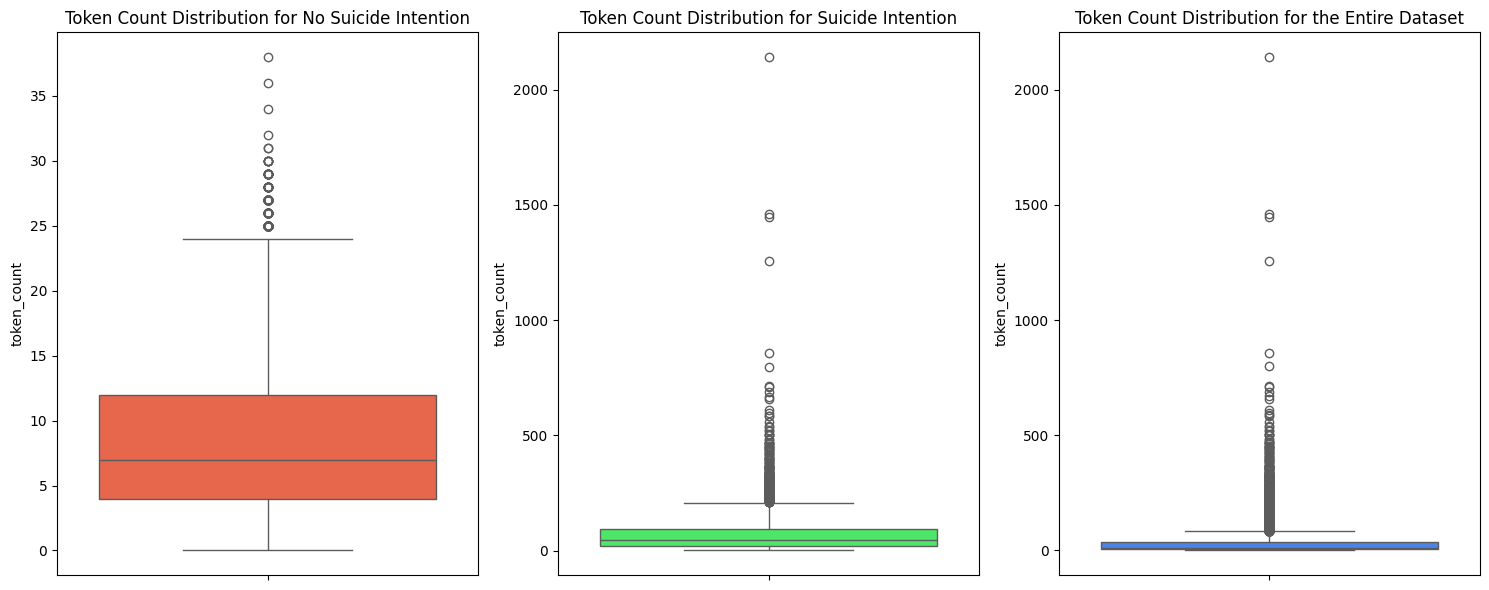

Intention 0:
Minimum Token Count: 0
Maximum Token Count: 38
Mean Token Count: 8.968756102323765

Intention 1:
Minimum Token Count: 1
Maximum Token Count: 2142
Mean Token Count: 73.64657328664332

Entire Dataset:
Minimum Token Count: 0
Maximum Token Count: 2142
Mean Token Count: 37.32514530101985


In [18]:
df_copy['token_count'] = df_copy['preprocessed_tweet'].apply(lambda x: len(x))

token_count_intention_0 = df_copy[df_copy['intention'] == 0]['token_count']
token_count_intention_1 = df_copy[df_copy['intention'] == 1]['token_count']

token_count_total = df_copy['token_count']

colors = ["#FF5733", "#33FF57", "#337CFF"]

plt.figure(figsize=(15, 6))
plt.subplot(1, 3, 1)
sns.boxplot(y=token_count_intention_0, color=colors[0])
plt.title('Token Count Distribution for No Suicide Intention')

plt.subplot(1, 3, 2)
sns.boxplot(y=token_count_intention_1, color=colors[1])
plt.title('Token Count Distribution for Suicide Intention')

plt.subplot(1, 3, 3)
sns.boxplot(y=token_count_total, color=colors[2])
plt.title('Token Count Distribution for the Entire Dataset')

plt.tight_layout()
plt.show()

print("Intention 0:")
print("Minimum Token Count:", token_count_intention_0.min())
print("Maximum Token Count:", token_count_intention_0.max())
print("Mean Token Count:", token_count_intention_0.mean())

print("\nIntention 1:")
print("Minimum Token Count:", token_count_intention_1.min())
print("Maximum Token Count:", token_count_intention_1.max())
print("Mean Token Count:", token_count_intention_1.mean())

print("\nEntire Dataset:")
print("Minimum Token Count:", token_count_total.min())
print("Maximum Token Count:", token_count_total.max())
print("Mean Token Count:", token_count_total.mean())

---
## *Word2Vec - Word Embedding*

In [19]:
# print available word2vec models
import gensim.downloader as api
print("\n".join(api.info()['models'].keys()))

fasttext-wiki-news-subwords-300
conceptnet-numberbatch-17-06-300
word2vec-ruscorpora-300
word2vec-google-news-300
glove-wiki-gigaword-50
glove-wiki-gigaword-100
glove-wiki-gigaword-200
glove-wiki-gigaword-300
glove-twitter-25
glove-twitter-50
glove-twitter-100
glove-twitter-200
__testing_word2vec-matrix-synopsis


In [20]:
W2V_PATH = "hello"
if W2V_PATH is not None and os.path.exists(W2V_PATH):
    print("Loading Word2Vec model...")
    w2v_model = gensim.models.KeyedVectors.load(W2V_PATH, mmap='r')
    print("Word2Vec model is loaded.")
else:
    print("Downloading Word2Vec model...")
    w2v_model = api.load("word2vec-google-news-300")
    print("Word2vec model is downloaded.")
    if W2V_PATH is not None:
      print("\nSaving Word2Vec model...")
      w2v_model.save(W2V_PATH)
      print("Word2Vec model is saved.")

[==================================================] 100.0% 1662.8/1662.8MB downloaded
Word2vec model is downloaded.

Saving Word2Vec model...
Word2Vec model is saved.


In [21]:
EMBEDDING_VECTOR_DIM = w2v_model.vector_size

## *Dataset*

In [22]:
class Twitter(Dataset):
    def __init__(self, dataframe: pd.DataFrame, w2v_model: gensim.models.KeyedVectors, sequence_len: int):
        self.dataframe = dataframe
        self.w2v_model = w2v_model
        self.max_sequence_len = sequence_len
        self.vector_size = w2v_model.vector_size
        self.df_token_col = "tokens"
        self._proc_dataset()

        self.len = len(self.dataframe)

    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        return self.dataframe.iloc[idx]["vector"], self.dataframe.iloc[idx]["intention"]

    def get_vector_size(self):
        return self.vector_size

    def _proc_dataset(self):
        # Preprocess and return tokens list
        self.dataframe[self.df_token_col] = self.dataframe["tweet"].map(preprocess_data)

        # delete samples with empty tokens
        lwz = len(self.dataframe)
        self.dataframe = self.dataframe[self.dataframe[self.df_token_col].map(len) > 0]
        self.dataframe.reset_index(drop=True, inplace=True)
        print(f"Deleted 0-Len Samples: {lwz - len(self.dataframe)}")

        # Add padding
        self.dataframe[self.df_token_col] = self.dataframe[self.df_token_col].map(self._pad)

        # Get embedding's vectors
        self.dataframe["vector"] = self.dataframe[self.df_token_col].map(self._get_word_vectors)

    def _get_word_vectors(self, tokens: list) -> torch.tensor:
        vectors = []
        for token in tokens:
            if token in self.w2v_model:
                vectors.append(self.w2v_model[token])
            else:
                vectors.append(np.zeros(self.vector_size))
        return torch.tensor(vectors, dtype=torch.float32)

    def _pad(self, tokens: list):
        if len(tokens) < self.max_sequence_len:
            tokens += ([0] * (self.max_sequence_len - len(tokens)))
        else:
            tokens = tokens[:self.max_sequence_len]
        return tokens

    def seq_report(self):
        length_all = self.dataframe[self.df_token_col].map(len).tolist()
        max_length = np.max(length_all)
        print(f"Sequence Length Report")
        print(f":::::MAX  LENGTH:::[{max_length:^5}]")
        print(f":::::MIN  LENGTH:::[{np.min(length_all):^5}]")
        print(f":::::MEAN LENGTH:::[{np.mean(length_all):^5}]")

        all_tokens = set()
        for token_set in self.dataframe[self.df_token_col].tolist():
            all_tokens = all_tokens.union(set(token_set))
        unique_tokens_count = len(all_tokens)
        valid_tokens = sum(1 if token in self.w2v_model else 0 for token in all_tokens)
        print("Sequence Tokenization Report")
        print(f":::::All Unique Tokens:::[{unique_tokens_count:^6}")
        print(f":::::All Valid Tokens:::[{valid_tokens:^6}")
        print(f":::::Valid Tokens:::[{round(100*valid_tokens/unique_tokens_count, 2):^5}%]")

        return self.dataframe

    @staticmethod
    def _to_tensor(tokens: list):
        return torch.tensor(tokens, dtype=torch.float32)


---
## *Prepare Data*

### *Split Data into train-test datasets*

In [24]:
train_data, test_data = train_test_split(df, test_size=0.25, random_state=42)

### *Create Datasets*

In [ ]:
train_dataset = Twitter(
    train_data,
    w2v_model,
    SEQUENCE_LEN
)
test_dataset = Twitter(
    test_data,
    w2v_model,
    SEQUENCE_LEN
)

---
## *Model and Train*

### *Utils*

In [26]:
@torch.no_grad()
def model_eval(
        model,
        loader,
        loss_function,
        device: str = 'auto'
):
    """Returns test_loss, test_acc"""
    test_loss = 0.0
    test_acc = 0.0
    total_samples = 0
    correct_samples = 0

    if device == "auto":
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = model.to(device)
    itr = tqdm(loader, total=len(loader), leave=True)

    for inputs, labels in itr:
        # Move model's inputs and labels to `device`
        inputs, labels = inputs.to(device), labels.to(device)

        # Use model's forward pass to generate outputs
        outputs = model(inputs)

        # Calculate model's loss
        loss = loss_function(outputs, labels)
        test_loss += loss.item()

        # Calculate/update model's accuracy
        _, predicted = torch.max(outputs, 1)
        correct_samples += (predicted == labels).sum().item()
        total_samples += labels.size(0)
        test_acc = correct_samples / total_samples

        itr.set_description("(Eval)")
        itr.set_postfix(
            loss=round(loss.item(), 5),
            accuracy=round(test_acc, 5),
        )
    test_loss /= len(itr)
    return test_loss, test_acc

In [27]:
def trend_plot_helper(pobj):
    plt.figure(figsize=(5*len(pobj), 5))
    for idx, (titler, plots) in enumerate(pobj.items(), start=1):
        plt.subplot(1, len(pobj), idx)
        for label, trend in plots:
            plt.plot(range(1, len(trend)+1), trend, label=label)
        yt, xt = titler.split(' - ')
        plt.xlabel(xt)
        plt.ylabel(yt)
        plt.legend()

In [47]:
@torch.no_grad()
def generate_confusion_matrix(model, dataset, device='auto'):
    if device == 'auto':
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    loader = DataLoader(dataset, batch_size=32, shuffle=False)
    itr = tqdm(loader, leave=False, desc="Generate data")

    labels = []
    predicted = []

    with torch.no_grad(): 
        for data in itr:
            inputs, targets = data  
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            labels.extend(targets.cpu().numpy())
            predicted.extend(preds.cpu().numpy())

    cm = metrics.confusion_matrix(
        y_true=labels,
        y_pred=predicted,
    )

    plt.figure(figsize=(6,6))
    sns.heatmap(cm, cmap=sns.color_palette("ch:s=0 ,r=.5", as_cmap=True), annot=True, cbar=False, fmt=".0f",)
    plt.xlabel('Predicted Label', labelpad=20)
    plt.ylabel('True Label', labelpad=20)
    plt.title('Confusion Matrix', fontsize=30)

    recall = metrics.recall_score(y_true=labels, y_pred=predicted, average='macro')
    f1 = metrics.f1_score(y_true=labels, y_pred=predicted, average='macro')
    precision = metrics.precision_score(y_true=labels, y_pred=predicted, average='macro')
    report = metrics.classification_report(y_true=labels, y_pred=predicted)

    return {'recall': recall, 'f1': f1, 'precision': precision, 'report': report}


In [29]:
def train_model(
        model,
        batch_size,
        loss_function,
        optimizer,
        epochs,
        train_set,
        test_set,
        device: str = 'auto',
):

    if device == "auto":
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    train_losses = []
    train_accs = []
    test_losses = []
    test_accs = []

    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)


    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        epoch_acc = 0
        epoch_correct = 0
        epoch_total = 0
        itr = tqdm(train_loader, total=len(train_loader), leave=True, desc=f"(Training) Epoch [{epoch + 1}/{epochs}]")

        for idx, (inputs, labels) in enumerate(itr, start=1):
            # Move model's inputs to `device`
            inputs, labels = inputs.to(device), labels.to(device)

            # Use model's forward pass to generate outputs
            outputs = model(inputs)

            # Process model's predictions and calculate/update accuracy
            _, predicted = torch.max(outputs, 1)
            epoch_correct += (predicted == labels).sum().item()
            epoch_total += labels.size(0)
            epoch_acc = epoch_correct / epoch_total

            # Calculate model's loss and update epoch's loss
            loss = loss_function(outputs, labels)
            epoch_loss += loss.item()

            # Clear optimizer's state and zero prev grads, backward calculated loss, step optimizer
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            itr.set_description(f"(Training) Epoch [{epoch + 1}/{epochs}]")
            itr.set_postfix(
                loss=round(loss.item(), 5),
                accuracy=round(epoch_acc, 5),
            )

        epoch_loss /= len(itr)

        model.eval()

        test_loss, test_acc = model_eval(
            model=model,
            loader=test_loader,
            loss_function=loss_function,
            device=device
        )

        # Update statistics regarding model's loss and acc in training or testation phases
        train_losses.append(epoch_loss)
        train_accs.append(epoch_acc)
        test_losses.append(test_loss)
        test_accs.append(test_acc)


    history = {
      "train_loss": train_losses,
      "train_acc": train_accs,

      "test_loss": test_losses,
      "test_acc": test_accs,
    }
    return history

---
## *Model's Network*

In [30]:
class CNN(nn.Module):
    def __init__(self, context=64, reg=False):
        super(CNN, self).__init__()
        self.reg = reg
        self.conv1_3 = nn.Conv1d(in_channels=context, out_channels=64, kernel_size=3, padding=1)
        self.conv1_5 = nn.Conv1d(in_channels=context, out_channels=64, kernel_size=5, padding=2)
        self.conv1_7 = nn.Conv1d(in_channels=context, out_channels=64, kernel_size=7, padding=3)

        self.bn1_3 = nn.BatchNorm1d(64)
        self.bn1_5 = nn.BatchNorm1d(64)
        self.bn1_7 = nn.BatchNorm1d(64)

        self.dropout = nn.Dropout(0.5)

        self.conv2_3 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv2_5 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=5, padding=2)
        self.conv2_7 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=7, padding=3)

        self.bn2_3 = nn.BatchNorm1d(128)
        self.bn2_5 = nn.BatchNorm1d(128)
        self.bn2_7 = nn.BatchNorm1d(128)

        self.maxpool = nn.MaxPool1d(kernel_size=2)

        self.global_avg_pool = nn.AdaptiveAvgPool1d(1)

        self.flatten = nn.Flatten()

        self.fc1 = nn.Linear(3 * 128, 128)
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):

        x1_3 = F.relu(self.conv1_3(x))
        x1_5 = F.relu(self.conv1_5(x))
        x1_7 = F.relu(self.conv1_7(x))

        if (self.reg):
          x1_3 = self.dropout(x1_3)
          x1_5 = self.dropout(x1_5)
          x1_7 = self.dropout(x1_7)

        x2_3 = None
        x2_5 = None
        x2_7 = None

        if (self.reg):
          x2_3 = F.relu(self.bn2_3(self.conv2_3(x1_3)))
          x2_5 = F.relu(self.bn2_5(self.conv2_5(x1_5)))
          x2_7 = F.relu(self.bn2_7(self.conv2_7(x1_7)))

        else:
          x2_3 = F.relu(self.conv2_3(x1_3))
          x2_5 = F.relu(self.conv2_5(x1_5))
          x2_7 = F.relu(self.conv2_7(x1_7))

        if (self.reg):
          x2_3 = self.dropout(x2_3)
          x2_5 = self.dropout(x2_5)
          x2_7 = self.dropout(x2_7)

        x2_3 = self.maxpool(x2_3)
        x2_5 = self.maxpool(x2_5)
        x2_7 = self.maxpool(x2_7)

        x2_3 = self.global_avg_pool(x2_3)
        x2_5 = self.global_avg_pool(x2_5)
        x2_7 = self.global_avg_pool(x2_7)

        x = torch.cat((x2_3, x2_5, x2_7), dim=1)

        x = self.flatten(x)

        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x

---
## *Training*

In [60]:
cnn_model = CNN()

### *Question 1 : Adam Optimizer*
*The Adam optimizer is a powerful optimization algorithm used in training neural networks. It combines the advantages of two other popular optimization methods: AdaGrad and RMSProp. Adam stands for Adaptive Moment Estimation.*

***How Adam Works:***

*Adam maintains adaptive learning rates for each parameter by estimating the first and second moments of the gradients.*
*It computes the exponentially decaying average of past gradients and their square, similar to RMSProp.
Adam also incorporates bias correction to compensate for the initialization biases towards zero in the first few time steps.*


***Difference Between Adam and SGD:***

1. ``Adaptive Learning Rates:`` *While SGD uses a fixed learning rate throughout training, Adam adapts the learning rate for each parameter. This adaptivity helps in converging faster and avoiding potential issues like vanishing or exploding gradients.*
2. ``Momentum:`` *Adam incorporates momentum, allowing it to overcome local minima and saddle points more efficiently compared to vanilla SGD.*
3. ``Bias Correction:`` *Adam performs bias correction to mitigate the effects of the initialization biases in the first few time steps, leading to more stable and reliable updates.*
4. ``Automatic Adjustment:`` *Adam automatically adjusts the learning rates based on the gradients' magnitudes, whereas in SGD, choosing an appropriate learning rate often requires manual tuning.*

*while SGD is simple and can be effective with the right learning rate, Adam is more sophisticated, adapting learning rates and incorporating momentum and bias correction to improve optimization performance on a wide range of problems.*

### *Question 2 : Cross Entropy Cost Function*

*The equation for the binary cross-entropy loss function is:*

$$L=-\frac{1}{N}\sum_{i=1}^{N}[y_{i}log(p_{i})+(1-y_{i})log(1-p_{i})]$$

*where:*

* $L$ *represents the loss function.*
* $N$ *is the number of data points.*
* $y_i$ *is the binary dependent variable for the i-th data point, where 1 indicates a positive outcome and 0 indicates a negative outcome.*
* $p_i$ *is the predicted probability of a positive outcome for the i-th data point.*


*Reasons for Using Cross Entropy Loss in This Problem*

- ``Handling Imbalanced Classes:``

    *In the context of suicidal tweet detection, there is often a class imbalance (fewer suicidal tweets compared to non-suicidal ones). Cross Entropy Loss effectively handles such imbalances by penalizing incorrect predictions based on the predicted probability.*

- ``Probabilistic Interpretation:``

    *Cross Entropy Loss provides a probabilistic interpretation of the model's confidence. This is crucial for sensitive applications like suicide detection, where understanding the confidence of predictions can aid in making more informed decisions.*

- ``Suitability for NLP and CNN Models:``

    *When using NLP techniques like Word2Vec to represent tweets as vectors and CNNs to capture spatial hierarchies in these representations, Cross Entropy Loss is well-suited to optimize the model parameters, ensuring effective learning and accurate classification.*

- ``Smooth Gradient and Efficient Learning:``

    *The Cross Entropy Loss function provides smooth gradients, which are beneficial for the training of deep neural networks. This smoothness ensures that the gradients do not vanish or explode, leading to more stable and efficient learning.*

### *Question 3 : Train-Test Split and Ratio Justification*
- *Sufficient Training Data:*

    *A 75% allocation for training ensures that the model has enough data to learn from. This is particularly important for complex models like CNNs that require substantial data to capture intricate patterns.*

- *Reliable Evaluation:*

    Allocating 25% for testing provides a reasonable amount of data to assess the model’s performance. This balance helps in obtaining statistically significant results and ensures that the evaluation metrics (such as accuracy, precision, recall) are reliable.*

- *Avoiding Overfitting:*

    *By keeping a significant portion of the data for testing, we can better detect overfitting. If the model performs well on the training data but poorly on the testing data, it indicates overfitting.*

- *Common Practice:*

    *The 75/25 split is a commonly used ratio in machine learning, especially when the dataset is of moderate to large size. It provides a good trade-off between training the model adequately and having enough data to validate its performance.*


### *Question 4 : The Impact of Kernel Size in Convolutional Layers*
*The kernel size in convolutional layers has a significant impact on the performance and operations of convolutional neural networks (CNNs). It directly affects the feature extraction process from the input data and can influence the effectiveness of feature extraction.*

***Kernel Size and Nature of Features:***

- *Smaller kernel sizes are typically more suitable for extracting local and detailed features such as edges and fine textures.*
- *Larger kernel sizes are better at capturing broader patterns and global features in the input.*

***Spatial Coverage:***

*The size of the kernel determines the receptive field, which is the area of the input that each convolutional neuron observes. Larger kernel sizes cover a broader spatial area, while smaller ones focus on smaller regions.*

***Parameter Efficiency:***

- *Smaller kernel sizes have fewer parameters and are computationally efficient, making them suitable for models with limited resources.*
- *Larger kernel sizes introduce more parameters, potentially leading to higher model complexity and increased computational cost.*

***Hierarchical Representation:***

*CNNs often use multiple convolutional layers with different kernel sizes to build hierarchical representations of the input data. Starting with smaller kernels for low-level features and gradually increasing the kernel size to capture higher-level features.*


***Trade-off:***

*The choice of kernel size involves a trade-off between capturing detailed features and computational efficiency. While larger kernel sizes can capture more context and global information, they also increase computational complexity.*

### *Question 5 : feed forward Layers*
*Retaining the output size in convolutional layers and introducing feed forward layers afterward is a strategic choice in deep learning architectures. By preserving spatial information through convolutional layers, the model maintains fine-grained details crucial for tasks like object detection and semantic segmentation. This approach enables the model to better handle scale variability and improve localization accuracy. Introducing feed forward layers afterward provides flexibility in feature transformation and abstraction, leading to richer feature representations and enhanced performance in various computer vision tasks. Research findings support the effectiveness of this approach, showcasing its benefits in gradient flow during training, pixel-wise predictions in semantic segmentation, and precise object localization in object detection tasks.*

In [61]:
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn_model.parameters(), lr=LEARNING_RATE)

cnn_model_train_history = train_model(
    model = cnn_model,
    batch_size = BATCH_SIZE,
    loss_function = loss_function,
    optimizer = optimizer,
    epochs = EPOCHS,
    train_set = train_dataset,
    test_set = test_dataset,
    device = DEVICE
)

(Eval): 100%|██████████| 36/36 [00:00<00:00, 49.40it/s, accuracy=0.852, loss=0.272]


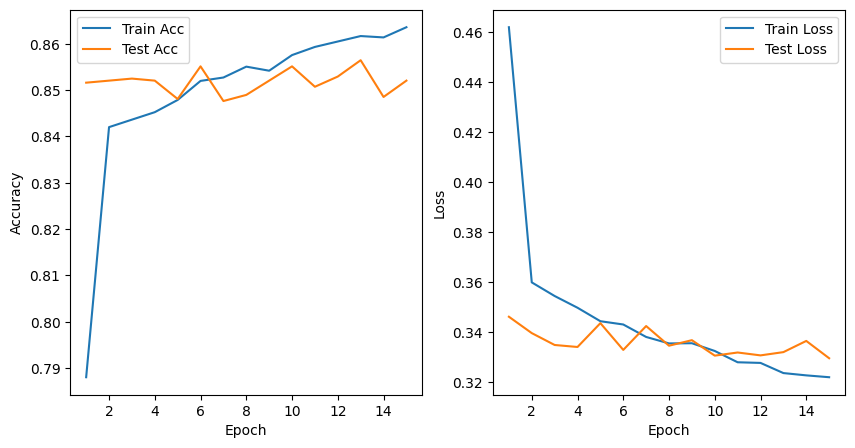

In [62]:
trend_plot_helper(
    {
        "Accuracy - Epoch": [
            ("Train Acc", cnn_model_train_history["train_acc"]),
            ("Test Acc", cnn_model_train_history["test_acc"]),
        ],
        "Loss - Epoch": [
            ("Train Loss", cnn_model_train_history["train_loss"]),
            ("Test Loss", cnn_model_train_history["test_loss"])
        ]
    }
)



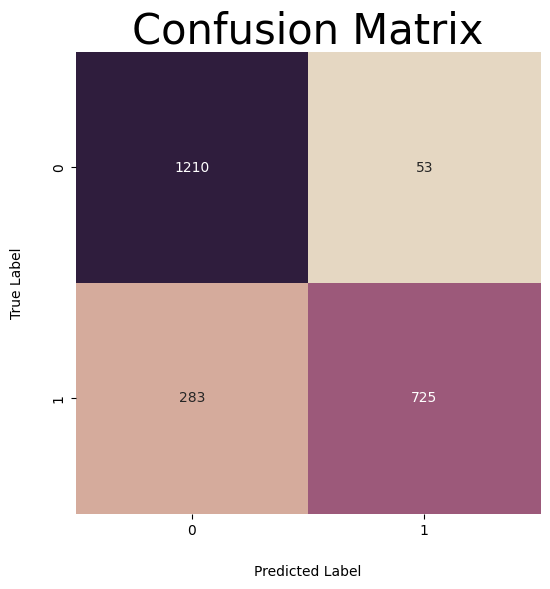

In [64]:
cnn_model_report = generate_confusion_matrix(
    model = cnn_model,
    dataset = test_dataset,
)

In [65]:
print(f"Recall:    {cnn_model_report['recall']:.3f}")
print(f"F1:        {cnn_model_report['f1']:.3f}")
print(f"Precision: {cnn_model_report['precision']:.3f}")
print(cnn_model_report['report'])

Recall:    0.839
F1:        0.845
Precision: 0.871
              precision    recall  f1-score   support

           0       0.81      0.96      0.88      1263
           1       0.93      0.72      0.81      1008

    accuracy                           0.85      2271
   macro avg       0.87      0.84      0.84      2271
weighted avg       0.86      0.85      0.85      2271



---
## *Context window*

In [56]:
train_dataset196 = Twitter(
    train_data,
    w2v_model,
    SEQUENCE_LEN_WINDOW_CONTEXT

)
test_dataset196 = Twitter(
    test_data,
    w2v_model,
    SEQUENCE_LEN_WINDOW_CONTEXT
)

Deleted 0-Len Samples: 22
Deleted 0-Len Samples: 9


### *Question 1 : Increasing Text Window Size in Convolutional Neural Networks*

***Pros:***

- ``Enhanced Local Information:`` *Increasing the text window size allows the network to extract more local information from the text. This can lead to higher accuracy in detecting patterns and textual features.*

- ``Improved Regularization:`` *A larger window size can help reduce the effects of noise and the addition of non-informative information in the text, which may improve model accuracy and performance.*

- ``Better Understanding of Concepts:`` *With access to more portions of the text, the network may have a better ability to understand and interpret the concepts and meanings of the text.*

***Cons:***

- ``Increased Model Complexity:`` *Using larger windows may increase the complexity of the model and the number of its parameters, which may lead to longer training times and increased computational resources.*

- ``Extended Training Time:`` *Increasing the window size may significantly increase the training time of the model, as the network needs to work with a larger volume of data.*

- ``May Include Unnecessary Information:`` *With a larger window size, there is a possibility of including unnecessary information or additional noise in the model, which may decrease accuracy and efficiency.*

In [57]:
cnn_model_with_wincontext = CNN(context=196)

In [58]:
optimizer = torch.optim.Adam(cnn_model_with_wincontext.parameters(), lr=LEARNING_RATE)
cnn_model_with_wincontext_train_history = train_model(
    model = cnn_model_with_wincontext,
    batch_size = BATCH_SIZE,
    loss_function = loss_function,
    optimizer = optimizer,
    epochs = 15,
    train_set = train_dataset196,
    test_set = test_dataset196,
    device = DEVICE
)

(Eval): 100%|██████████| 36/36 [00:00<00:00, 40.26it/s, accuracy=0.86, loss=0.296]


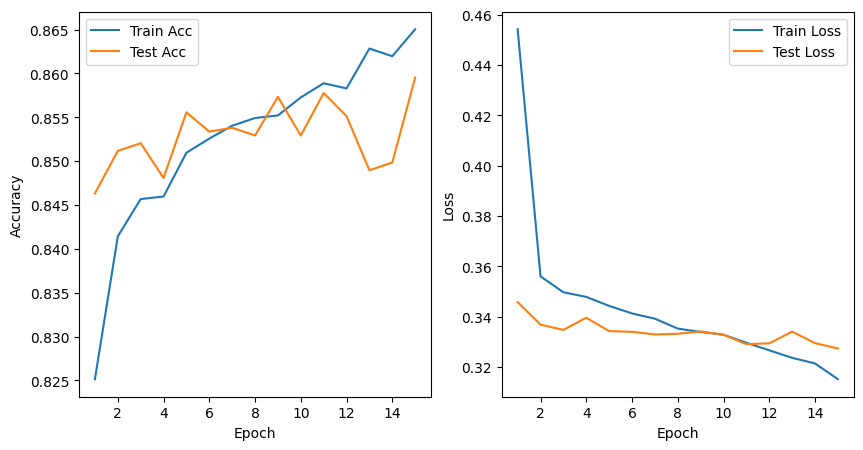

In [59]:
trend_plot_helper(
    {
        "Accuracy - Epoch": [
            ("Train Acc", cnn_model_with_wincontext_train_history["train_acc"]),
            ("Test Acc", cnn_model_with_wincontext_train_history["test_acc"]),
        ],
        "Loss - Epoch": [
            ("Train Loss", cnn_model_with_wincontext_train_history["train_loss"]),
            ("Test Loss", cnn_model_with_wincontext_train_history["test_loss"])
        ]
    }
)

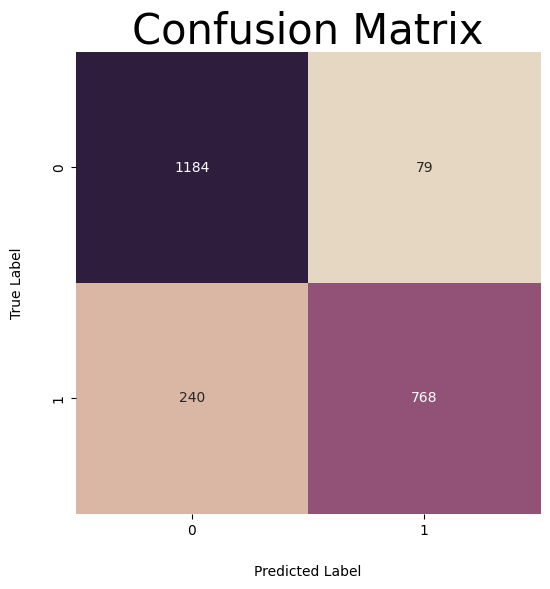

In [66]:
cnn_model_196_report = generate_confusion_matrix(
    model = cnn_model_with_wincontext,
    dataset = test_dataset196,
)

In [67]:
print(f"Recall:    {cnn_model_196_report['recall']:.3f}")
print(f"F1:        {cnn_model_196_report['f1']:.3f}")
print(f"Precision: {cnn_model_196_report['precision']:.3f}")
print(cnn_model_196_report['report'])

Recall:    0.850
F1:        0.855
Precision: 0.869
              precision    recall  f1-score   support

           0       0.83      0.94      0.88      1263
           1       0.91      0.76      0.83      1008

    accuracy                           0.86      2271
   macro avg       0.87      0.85      0.85      2271
weighted avg       0.86      0.86      0.86      2271




### *Analysis of Results with the change of context window*


##### *Observations:*

1. **Recall**:
   - *The recall is slightly higher with the original window context size of 64 (0.850) compared to the larger window context of 196 (0.839). This suggests that the model with the smaller window context is slightly better at identifying relevant instances correctly.*

2. **F1 Score**:
   - *The F1 score is also higher with the original window context size of 64 (0.855) compared to 196 (0.845). This indicates a better balance between precision and recall in the smaller window context.*

3. **Precision**:
   - *Precision is marginally higher with the larger window context of 196 (0.871) compared to the original size of 64 (0.869). However, the difference is negligible.*

4. **Class Performance**:
   - *For **Class 0**, both configurations show similar F1-scores (0.88). However, the recall for Class 0 is slightly better with the larger window context (0.96 vs. 0.94).*
   - *For **Class 1**, the F1-score is better with the original window context of 64 (0.83 vs. 0.81). The recall is notably better with the original context (0.76 vs. 0.72), indicating the smaller window context is more effective in correctly identifying Class 1 instances.*

5. **Accuracy**:
   - *The overall accuracy is slightly higher with the original window context size of 64 (0.86) compared to the larger window context of 196 (0.85).*


##### *Conclusion:*
*The observations are largely consistent with expectations. Although larger window contexts can theoretically capture more information, they also increase the model's complexity and the risk of overfitting. The results show that the original window context size of 64 provides a slightly better balance of precision, recall, and F1-score, suggesting that it may be more effective for this particular dataset and task. This indicates that the model is likely trained correctly, and the smaller window context size (64) is sufficient for capturing relevant features without the drawbacks of increased complexity associated with larger window sizes.*

---
##  *Regularization*

In [74]:
cnn_model_with_reg = CNN(reg=True)

In [75]:
optimizer = torch.optim.Adam(cnn_model_with_reg.parameters(), lr=LEARNING_RATE)
cnn_model_with_reg_train_history = train_model(
    model = cnn_model_with_reg,
    batch_size = BATCH_SIZE,
    loss_function = loss_function,
    optimizer = optimizer,
    epochs = EPOCHS,
    train_set = train_dataset,
    test_set = test_dataset,
    device = DEVICE
)

(Eval): 100%|██████████| 36/36 [00:00<00:00, 51.85it/s, accuracy=0.86, loss=0.321]


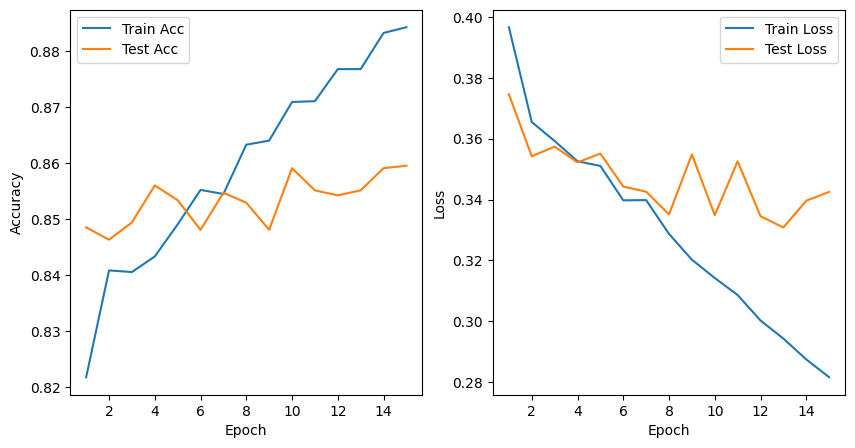

In [76]:
trend_plot_helper(
    {
        "Accuracy - Epoch": [
            ("Train Acc", cnn_model_with_reg_train_history["train_acc"]),
            ("Test Acc", cnn_model_with_reg_train_history["test_acc"]),
        ],
        "Loss - Epoch": [
            ("Train Loss", cnn_model_with_reg_train_history["train_loss"]),
            ("Test Loss", cnn_model_with_reg_train_history["test_loss"])
        ]
    }
)

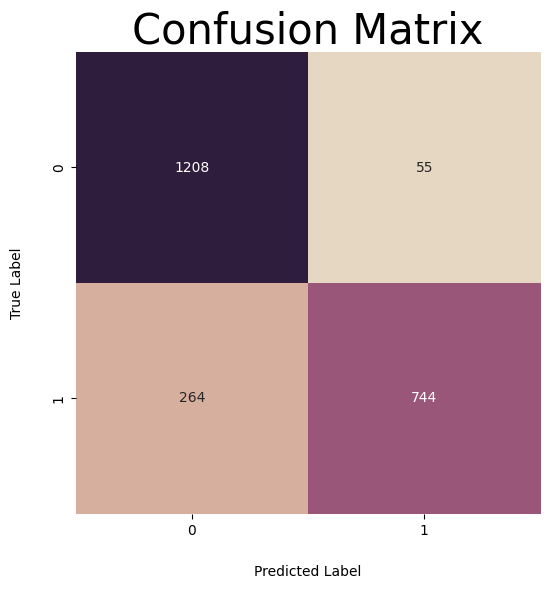

In [78]:
cnn_model_reg_report = generate_confusion_matrix(
    model = cnn_model_with_reg,
    dataset = test_dataset,
)

In [79]:
print(f"Recall:    {cnn_model_reg_report['recall']:.3f}")
print(f"F1:        {cnn_model_reg_report['f1']:.3f}")
print(f"Precision: {cnn_model_reg_report['precision']:.3f}")
print(cnn_model_196_report['report'])

Recall:    0.847
F1:        0.853
Precision: 0.876
              precision    recall  f1-score   support

           0       0.83      0.94      0.88      1263
           1       0.91      0.76      0.83      1008

    accuracy                           0.86      2271
   macro avg       0.87      0.85      0.85      2271
weighted avg       0.86      0.86      0.86      2271



### *Analysis of Results with Batch Normalization and Dropout*

##### *Observations:*

1. **Recall**:
   - *The recall with batch normalization and dropout is slightly lower (0.847) compared to the original model (0.850). This indicates a minor reduction in the model's ability to correctly identify relevant instances.*

2. **F1 Score**:
   - *The F1 score is slightly lower with batch normalization and dropout (0.853) compared to the original model (0.855). This suggests a small decrease in the balance between precision and recall.*

3. **Precision**:
   - *Precision is slightly higher with batch normalization and dropout (0.876) compared to the original model (0.869). This indicates a slight improvement in the model's ability to correctly classify positive instances.*

4. **Class Performance**:
   - *For **Class 0**, the metrics remain the same across both models.*
   - *For **Class 1**, the performance remains the same, with a slight difference in the overall precision and recall.*

5. **Accuracy**:
   - *The overall accuracy remains consistent at 0.86 for both models.*

##### *Conclusion:*
*The introduction of batch normalization and dropout shows minimal changes in the model's performance. While the recall and F1 score are slightly reduced, precision sees a minor improvement. Overall, these regularization techniques help in preventing overfitting, which is beneficial for generalization to new, unseen data. The minor changes in metrics suggest that the model is now more robust and better at handling noise and small variations in the input data, although the impact on these specific metrics is relatively small.*